In [1]:
import os
import cv2
import numpy as np

import timm

import gc
import os
import time
import random
from datetime import datetime

from PIL import Image
from tqdm.notebook import tqdm
from sklearn import model_selection, metrics

import torch
import torch.nn as nn
import torchvision.transforms as transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
TRAIN_PATH = "../cassava-leaf-disease-classification/train_images_2"
TEST_PATH = "../cassava-leaf-disease-classification/test_images"

# model specific global variables
IMG_SIZE = 224
BATCH_SIZE = 16
LR = 1e-05
GAMMA = 0.7
N_EPOCHS = 10

DATA_PATH = './'
df = pd.read_csv(os.path.join(DATA_PATH, "train_2.csv"))

In [3]:
def seed_everything(seed):
    """
    Seeds basic parameters for reproductibility of results
    
    Arguments:
        seed {int} -- Number of the seed
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(110)

In [4]:
class CassavaDataset(torch.utils.data.Dataset):
    """
    Helper Class to create the pytorch dataset
    """

    def __init__(self, df, data_path=DATA_PATH, mode="train", transforms=None):
        super().__init__()
        self.df_data = df.values
        self.data_path = data_path
        self.transforms = transforms
        self.mode = mode
        self.data_dir = "train_images_2"

    def __len__(self):
        return len(self.df_data)

    def __getitem__(self, index):
        img_name, label = self.df_data[index]
        img_path = os.path.join(self.data_path, self.data_dir, img_name)
        img = Image.open(img_path).convert("RGB")

        if self.transforms is not None:
            image = self.transforms(img)

        return image, label

In [5]:
# create image augmentations
transforms_train = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.RandomResizedCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

transforms_valid = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

In [6]:
train_df, tem_df = model_selection.train_test_split(
    df, test_size=0.3, random_state=42, stratify=df.label.values
)

valid_df, test_df = model_selection.train_test_split(
    tem_df, test_size=0.5, random_state=42, stratify=tem_df.label.values
)

In [7]:
class ViTBase16(nn.Module):
    def __init__(self, n_classes):

        super(ViTBase16, self).__init__()

        self.model = timm.create_model("vit_base_patch16_224", pretrained=True)

        self.model.head = nn.Linear(self.model.head.in_features, n_classes)

    def forward(self, x):
        x = self.model(x)
        return x
    
    def train_one_epoch(self, train_loader, criterion, optimizer, device):
        # keep track of training loss
        epoch_loss = 0.0
        epoch_accuracy = 0.0

        ###################
        # train the model #
        ###################
        self.model.train()
        for i, (data, target) in enumerate(train_loader):
            # move tensors to GPU if CUDA is available
            data, target = data.to(device), target.to(device)

            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = self.forward(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # Calculate Accuracy
            accuracy = (output.argmax(dim=1) == target).float().mean()
            # update training loss and accuracy
            epoch_loss += loss.item()
            epoch_accuracy += accuracy.item()
            
            optimizer.step()

        return epoch_loss / len(train_loader), epoch_accuracy / len(train_loader)
    
    def validate_one_epoch(self, valid_loader, criterion, device):
        # keep track of validation loss
        valid_loss = 0.0
        valid_accuracy = 0.0

        ######################
        # validate the model #
        ######################
        self.model.eval()
        for data, target in valid_loader:
            # move tensors to GPU if CUDA is available
            
            data, target = data.to(device), target.to(device)

            with torch.no_grad():
                # forward pass: compute predicted outputs by passing inputs to the model
                output = self.model(data)
                # calculate the batch loss
                loss = criterion(output, target)
                # Calculate Accuracy
                accuracy = (output.argmax(dim=1) == target).float().mean()
                # update average validation loss and accuracy
                valid_loss += loss.item()
                valid_accuracy += accuracy.item()

        return valid_loss / len(valid_loader), valid_accuracy / len(valid_loader)
    
    def evaluate(self, test_loader, criterion, device):
        # keep track of test loss and accuracy
        test_loss = 0.0
        test_accuracy = 0.0
        all_preds = []
        all_targets = []

        ######################
        # evaluate the model #
        ######################
        self.model.eval()  # prep model for evaluation
        for data, target in test_loader:

            data, target = data.to(device), target.to(device)

            with torch.no_grad():
                # turn off gradients for evaluation
                output = self.model(data)
                loss = criterion(output, target)
                accuracy = (output.argmax(dim=1) == target).float().mean()
                test_loss += loss.item()
                test_accuracy += accuracy.item()

                preds = output.argmax(dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_targets.extend(target.cpu().numpy())

        # calculate average losses
        test_loss /= len(test_loader)
        test_accuracy /= len(test_loader)

        return test_loss, test_accuracy, np.array(all_preds), np.array(all_targets)

In [8]:
def fit(
    model, epochs, device, criterion, optimizer, train_loader, valid_loader=None
):

    valid_loss_min = np.Inf  # track change in validation loss

    # keeping track of losses as it happen
    train_losses = []
    valid_losses = []
    train_accs = []
    valid_accs = []

    for epoch in range(1, epochs + 1):
        gc.collect()

        print(f"{'='*50}")
        print(f"EPOCH {epoch} - TRAINING...")
        train_loss, train_acc = model.train_one_epoch(
            train_loader, criterion, optimizer, device
        )
        print(
            f"\n\t[TRAIN] EPOCH {epoch} - LOSS: {train_loss}, ACCURACY: {train_acc}\n"
        )
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        gc.collect()

        if valid_loader is not None:
            gc.collect()
            
            print(f"EPOCH {epoch} - VALIDATING...")
            valid_loss, valid_acc = model.validate_one_epoch(
                valid_loader, criterion, device
            )
            print(f"\t[VALID] LOSS: {valid_loss}, ACCURACY: {valid_acc}\n")
            valid_losses.append(valid_loss)
            valid_accs.append(valid_acc)
            gc.collect()

            # save model if validation loss has decreased
            if valid_loss <= valid_loss_min and epoch != 1:
                print(
                    "Validation loss decreased ({:.4f} --> {:.4f}).".format(
                        valid_loss_min, valid_loss
                    )
                )

            valid_loss_min = valid_loss

    return {
        "train_loss": train_losses,
        "valid_losses": valid_losses,
        "train_acc": train_accs,
        "valid_acc": valid_accs,
    }

In [9]:
model = ViTBase16(n_classes=5)

In [10]:
train_dataset = CassavaDataset(train_df, transforms=transforms_train)
valid_dataset = CassavaDataset(valid_df, transforms=transforms_valid)
# Use validation transforms for testing
test_dataset = CassavaDataset(test_df, transforms=transforms_valid)

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    num_workers=0,
)

valid_loader = torch.utils.data.DataLoader(
    dataset=valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=True,
    num_workers=0,
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=False,
    num_workers=0,
)

criterion = nn.CrossEntropyLoss()
device = torch.device("cpu")
model.to(device)

lr = LR
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

print(f"INITIALIZING TRAINING ")
start_time = datetime.now()
print(f"Start Time: {start_time}")

logs = fit(
    model=model,
    epochs=N_EPOCHS,
    device=device,
    criterion=criterion,
    optimizer=optimizer,
    train_loader=train_loader,
    valid_loader=valid_loader,
)

print(f"Execution time: {datetime.now() - start_time}")

INITIALIZING TRAINING 
Start Time: 2024-03-14 18:16:51.964380
EPOCH 1 - TRAINING...

	[TRAIN] EPOCH 1 - LOSS: 1.1070615688959757, ACCURACY: 0.6263888888888889

EPOCH 1 - VALIDATING...
	[VALID] LOSS: 0.7978948884540134, ACCURACY: 0.6875

EPOCH 2 - TRAINING...

	[TRAIN] EPOCH 2 - LOSS: 0.7466595600048701, ACCURACY: 0.7180555555555556

EPOCH 2 - VALIDATING...
	[VALID] LOSS: 0.620458980401357, ACCURACY: 0.7638888888888888

Validation loss decreased (0.7979 --> 0.6205).
EPOCH 3 - TRAINING...

	[TRAIN] EPOCH 3 - LOSS: 0.5530480368269814, ACCURACY: 0.8152777777777778

EPOCH 3 - VALIDATING...
	[VALID] LOSS: 0.5181284116374122, ACCURACY: 0.8055555555555556

Validation loss decreased (0.6205 --> 0.5181).
EPOCH 4 - TRAINING...

	[TRAIN] EPOCH 4 - LOSS: 0.4756770773066415, ACCURACY: 0.8375

EPOCH 4 - VALIDATING...
	[VALID] LOSS: 0.5681801835695902, ACCURACY: 0.7569444444444444

EPOCH 5 - TRAINING...

	[TRAIN] EPOCH 5 - LOSS: 0.36838215175602174, ACCURACY: 0.8680555555555556

EPOCH 5 - VALIDATING..

In [11]:
test_loss, test_acc, all_preds, all_targets = model.evaluate(test_loader, criterion, device)
print(f"\t[TEST] LOSS: {test_loss}, ACCURACY: {test_acc}\n")

	[TEST] LOSS: 0.7291536957025528, ACCURACY: 0.7964285731315612



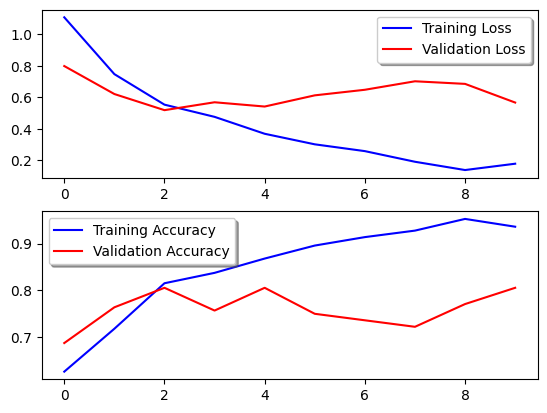

In [12]:
# plot the accuracy and loss values of training and validation with each epoch
fig, ax = plt.subplots(2,1)
ax[0].plot(logs['train_loss'], color='b', label="Training Loss")
ax[0].plot(logs['valid_losses'], color='r', label="Validation Loss")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(logs['train_acc'], color='b', label="Training Accuracy")
ax[1].plot(logs['valid_acc'], color='r',label="Validation Accuracy")
legend = ax[1].legend(loc='best', shadow=True)

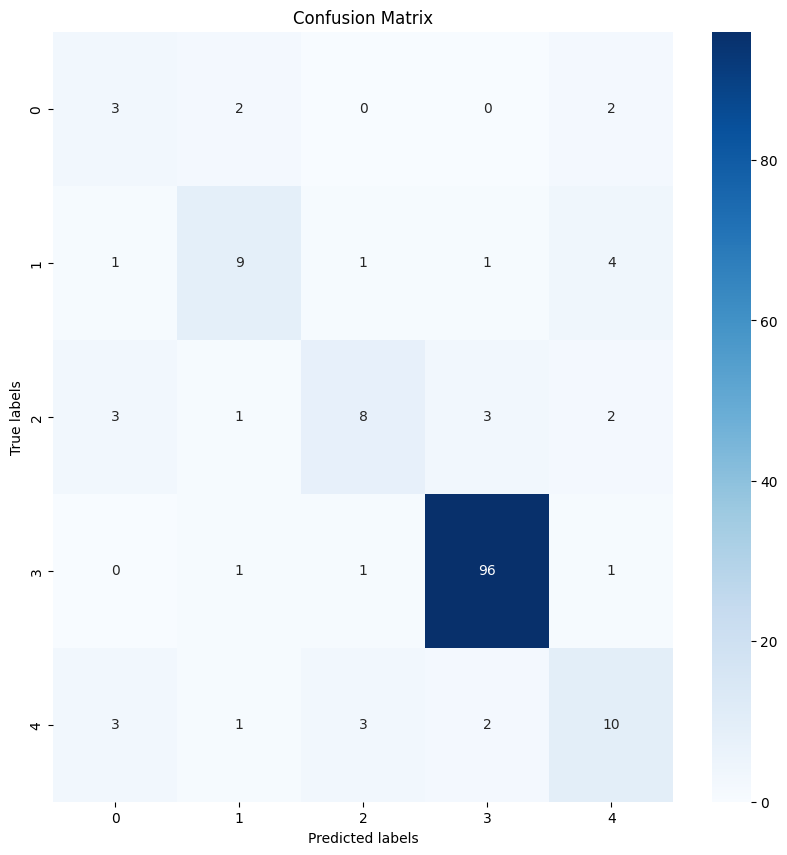

In [13]:
# 计算混淆矩阵
conf_mat = confusion_matrix(all_targets, all_preds)
fig, ax = plt.subplots(figsize=(10, 10))
# 使用Seaborn绘制混淆矩阵
sns.heatmap(conf_mat, annot=True, fmt='d', ax=ax, cmap="Blues")
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.show()

In [14]:
# make performance metrics for each classes
accuracy = accuracy_score(all_targets, all_preds)
num_classes = 5
print(accuracy)

0.7974683544303798


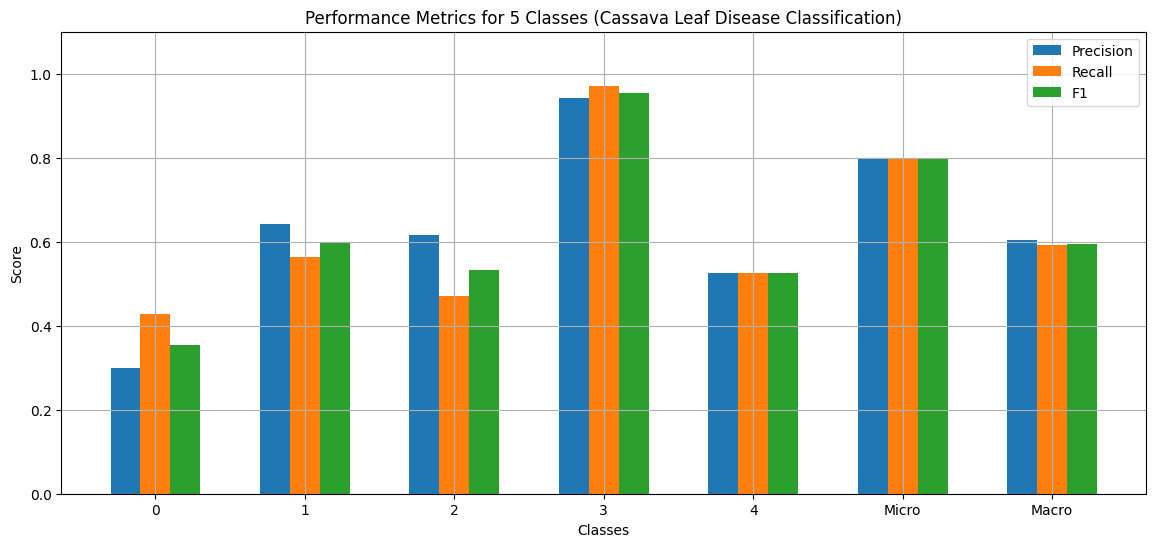

In [15]:
# define the values in normal, micro and macro state
precision = precision_score(all_targets, all_preds, average=None)
precision_micro = precision_score(all_targets, all_preds, average='micro')
precision_macro = precision_score(all_targets, all_preds, average='macro')

recall = recall_score(all_targets, all_preds, average=None)
recall_micro = recall_score(all_targets, all_preds, average='micro')
recall_macro = recall_score(all_targets, all_preds, average='macro')

f1 = f1_score(all_targets, all_preds, average=None)
f1_micro = f1_score(all_targets, all_preds, average='micro')
f1_macro= f1_score(all_targets, all_preds, average='macro')

precision = np.append(precision, [precision_micro, precision_macro])
recall = np.append(recall, [recall_micro, recall_macro])
f1 = np.append(f1, [f1_micro, f1_macro])
classes = list(range(num_classes)) + ['Micro', 'Macro']

x = np.arange(len(classes))
width = 0.2

fig1, ax1 = plt.subplots(figsize=(14, 6))
rects1 = ax1.bar(x - width, precision, width, label='Precision')
rects2 = ax1.bar(x, recall, width, label='Recall')
rects3 = ax1.bar(x + width, f1, width, label='F1')

ax1.set_xlabel('Classes')
ax1.set_ylabel('Score')
ax1.set_title('Performance Metrics for 5 Classes (Cassava Leaf Disease Classification)')
ax1.set_xticks(x)
ax1.set_xticklabels(classes)
ax1.set_ylim(0, 1.1)
ax1.legend(loc='upper right')
ax1.grid(True)
plt.show()